In [2]:
import pickle
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from cvxpy import *
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats.stats import pearsonr
from sklearn import linear_model
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rc('font',family='Times New Roman')

In [3]:
#VIF j столбца
def vifj(_X, j):
    #j in [0..n-1]
    X = np.copy(_X)
    (m, n) = X.shape
    
    Y = np.zeros((m, n-1))
    for k in range(0,j):
        Y.T[k] = X.T[k]
    for k in range(j+1, n):
        Y.T[k - 1] = X.T[k]
    Z = np.zeros(m)
    Z = X.T[j]
    
    temp = linear_model.LinearRegression()
    temp.fit(Y, Z)
    
    R = ((Y @ temp.coef_) - Z)
    Sj = R @ R
    TSS = np.sum((Z - np.mean(Z) * np.ones(m)) ** 2)
    return TSS / Sj

# максимум из VIF столбцов
def vif(X):
    (m,n) = X.shape
    res = vifj(X,0)
    for k in range(n):
        if (vifj(X, k) > res):
            res = vifj(X,k)
    return res        

In [4]:
def R(X):
    e = np.linalg.eigvals(X.T @ X)
    return np.log(np.min(e) / np.max(e))

# Загрузка данных

In [5]:
#загрузка данных
#period -- число признаков

f = open('data/data.txt')
data = np.transpose([float(line) for line in f])
period = 12

n = period * 10 #длина истории
r = period #горизонт прогнозирования
m = 10 #размер выборки
l = 3 #размер обучающей выборки
c = m - l #размер контрольной выборки
start = 7200 #start > year data = 365 * 12, start :: 12

a = np.array(range(12)) 
b = np.array(range(8 * 12)) - 8 * 12
mask = np.hstack((a - 365 * 12, a - 31 * 12, b))

Yl = np.array([data[start + 0 + period * i: start + 0 + period * i + r] for i in range(l)])
Yc = np.array([data[start + period * (l + i): start + period * (l + i) + r] for i in range(c)])
Xl = np.array([ [data[start + period * i + j] for j in mask] for i in range(l)])
Xc = np.array([ [data[start + period * (i + l) + j] for j in mask] for i in range(c)])

In [6]:
sm = np.ones(50)

In [7]:
print("k   AIC      BIC      Cp         r        v       Sa(k)        SMAPE(k)   avg")
#for k in range(2,10):
#    print(k, " %7.2f, %7.2f, %7.2f, %7.2f, %7.5f, %7.2f  %7.3f" % all(k,n,w))

for k in range(50):

    #загрузка данных
    #period -- число признаков

    f = open('data/data.txt')
    data = np.transpose([float(line) for line in f])
    period = 12

    n = period * 10 #длина истории
    r = period #горизонт прогнозирования
    m = 3000 #размер выборки
    l = 1000 #размер обучающей выборки
    c = m - l #размер контрольной выборки
    start = 7200 #start > year data = 365 * 12, start :: 12

    a = np.array(range(12)) 
    b = np.array(range(8 * 12)) - 8 * 12
    mask = np.hstack((a - 365 * 12, a - 31 * 12, b))

    Yl = np.array([data[start + 0 + period * i: start + 0 + period * i + r] for i in range(l)])
    Yc = np.array([data[start + period * (l + i): start + period * (l + i) + r] for i in range(c)])
    Xl = np.array([ [data[start + period * i + j] for j in mask] for i in range(l)])
    Xc = np.array([ [data[start + period * (i + l) + j] for j in mask] for i in range(c)])
    
    n_comp = k + 2
    pls = PLSRegression(n_components = n_comp, scale = False)
    pls.fit(Xl, Yl)
    # Y = XW + Err
    # X = TP^T
    # Y = UQ^T
    W = pls.coef_
    T = pls.x_scores_
    U = pls.y_scores_
    W = pls.x_weights_
    C = pls.y_weights_
    P = pls.x_loadings_
    Q = pls.y_loadings_

    Tc, Uc = pls.transform(Xc, Yc)
    predict = pls.predict(Xc)

    #        def all(k, n, w):
     #       Xa_test = select_QP(test_X, w, k)
    #      AIC = n * np.log(Sa(k) / n) + 2 * k
    #     BIC = n * np.log(Sa(k) / n) + k * np.log(n)
        #    Cp = Sa(k) / S(k) - n + 2 * k
         #   r = R(Xa_test)
        #  v = vif(Xa_test)
           # return (AIC,BIC,Cp,r,v,Sa(k))

    residuals = pls.predict(Xc) - Yc
    S_a = np.sum(residuals ** 2)

    lin = linear_model.LinearRegression(fit_intercept=False)
    lin.fit(Xl, Yl)
    S = np.sum((lin.predict(Xc) - Yc) ** 2)

    AIC = c * np.log(S_a / c) + 2 * n_comp
    BIC = c * np.log(S_a / c) + n_comp * np.log(c)
    Mallow_Cp = S_a / S - c + 2 * n_comp
    #устойчивость, VIF как определить?
    #r = ???
    
    #if (n_comp == 3):
    #    print(pls.predict(Xc))
    #    print(S_a)
    VIF_ = vif(Tc)
    r = R(Tc)

    SMAPE = np.mean(np.abs(np.divide(pls.predict(Xc) - Yc, (pls.predict(Xc) + Yc) / 2)))
    sm[n_comp] = SMAPE
    D = np.sqrt(S_a / (Yc.shape[0] * Yc.shape[1]))
    f = (AIC,BIC,Mallow_Cp,r,VIF_,S_a, SMAPE, D)
    #print("%7.2f, %7.2f, %7.2f, %7.2f, %7.5f, %7.2f" % f)
    print(n_comp, " %7.2f, %7.2f, %7.2f, %7.2f, %7.5f, %7.2f  %7.3f  %7.3f" % f)
#error = np.mean(np.abs((np.divide((pls.predict(Xc) - Yc), Yc))))
#print("maxerror = ", error)
#print("Mean squared error: %.4f"%np.mean((pls.predict(Xc) - Yc) ** 2))



k   AIC      BIC      Cp         r        v       Sa(k)        SMAPE(k)   avg
2  33879.83, 33891.03, -1993.24,   -1.32, 1.00116, 45401864768.46    0.063  1375.407
3  33465.67, 33482.47, -1991.76,   -2.07, 1.00116, 36872675532.94    0.055  1239.500
4  33247.53, 33269.93, -1989.99,   -2.07, 1.00623, 33029523204.44    0.052  1173.128
5  33119.07, 33147.08, -1988.12,   -2.63, 1.00914, 30943820205.92    0.051  1135.485
6  33059.73, 33093.33, -1986.18,   -3.62, 1.04121, 30009090738.42    0.050  1118.203
7  32993.62, 33032.83, -1984.24,   -3.66, 1.05928, 29004356196.89    0.049  1099.325
8  32907.46, 32952.27, -1982.31,   -3.67, 1.05690, 27753690970.44    0.048  1075.362
9  32845.42, 32895.83, -1980.37,   -3.67, 1.05670, 26879004049.48    0.047  1058.281
10  32813.13, 32869.14, -1978.39,   -3.92, 1.06890, 26422078722.40    0.046  1049.247
11  33339.14, 33400.75, -1975.91,   -4.51, 1.07260, 34336484563.67    0.054  1196.113
12  33078.62, 33145.83, -1974.17,   -5.08, 1.07350, 30112677382.43    

IndexError: index 50 is out of bounds for axis 0 with size 50

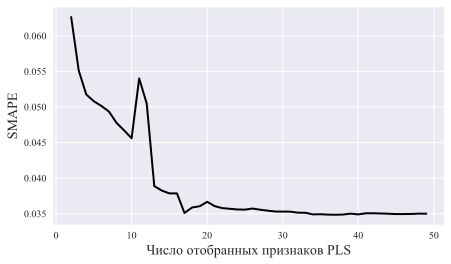

In [8]:
plt.figure(figsize=(7,4))
plt.plot(range(50)[2:], sm[2:], linewidth = 2, c = 'black')
plt.ylabel('SMAPE', FontSize =  14)
plt.xlabel('Число отобранных признаков PLS', FontSize =  14)
plt.axis([0, 30, 0, 0.07])
plt.axis('tight')
plt.savefig('PLS2.eps')
#plt.title('График зависимости $SMAPE$ от числа отобранных признаков в $PLS$')


#plt.plot(data[:12 * 365 * 3], linewidth = 0.4, c = 'black')
#plt.axis('tight')
##plt.ylabel('Амплитуда сигнала', FontSize =  14)
#plt.xlabel('Отсчеты времени, $t$', fontsize = 14)

In [ ]:
range(10)[2:]